# Az automatikus differenciálás alapjai

Tegyük fel, hogy adott egy $f:\mathbb{R}^n\to\mathbb{R}^m$ függvény, mely valamely $U\subset\mathbb{R}^n$ tartományon differenciálható és számítógép segítségével ki szeretnénk számítani $f$ derivált függvényét.


## Milyen lehetőségeket ismerünk $f'$ meghatározására és mi ezek hátránya?

*1. Lehetőség:* Az $f$ függvényt papíron deriváljuk és a deriváltat lekódoljuk. 

**Hátránya:** Az $f$ függvény rendkívül bonyolult lehet (bonyolult feltételes kiértékeléseket, rekurziókat, sokdimenziós nemlineáris műveleteket tartalmazhat, illetve problémáról problémára más és más lehet (gondoljunk például egy neurális háló átviteli függvényére, ahol a háló architektúrája az adott gépi tanulási feladattól nagyban függ), de akár futási időben is változhat.

*2. Lehetőség:* $f$-et kódoljuk le és szimbolikusan számítjuk ki a deriváltat (ahogy a Maple, SAGE, \textit{Mathematica} vagy egyéb computer algebra rendszer teszi). 

**Hátránya:** Lehetséges, hogy maga a $f$ függvény is nem valamilyen zárt formulával, hanem egy számítógépes kóddal adott. Így először a kódot kell formulává transzformálni, majd a kapott formulán szimbolikus műveleteket végrehajtani és végül behelyettesíteni az $x$ értéket és kiszámítani $f'(x)$-et, ami rendkívül művelet- és memóriaigényes. 

*3. Lehetőség:* $f$-et kódoljuk le és a deriváltját a numerikus módszerek tárgyból is tanult véges differenciák módszerével számítjuk ki. 

**Hátránya:** A numerikus deriválás eleve egy hibával terhelt közelítő értéket ad, a végeredmény pedig nagyban függ a lépésköz megválasztásától. Nem hagyhatjuk figyelmen kívül azt sem, hogy $f'$ kiszámításához $f$-et nagyságrendileg $O(n)$ különböző pontban kell kiértékelni, ami nagyon nagy $n$ esetén (pl.: neurális hálók súlyai sokdimenziós tér elemei) komoly műveletigénnyel bír.


## Mi az automatikus differenciálás?

* A számítógépes derivált számítás egy olyan új megközelítése, ami lehetővé teszi, hogy a függvény egyszeri kiértékelésével párhuzamosan automatikusan megkapjuk az adott pontbeli deriváltat is.

* Az autograd sem nem numerikus, sem nem szimbolikus deriválás, a derivált numerikus értékét adja vissza, de ehhez szimbolikus úton: a láncszabály többszöri, rekurzív alkalmazásával jut el. 

* Durván szólva arról van szó, hogy bármennyire is összetett egy numerikus számításokat végző program, a futás során a számítógép elemi műveletek (összeadás, kivonás, szorzás, osztás, stb.) sorát hajtja végre, illetve elemi függvényeket (exp, log, sin, cos, stb.) számol. Az autograd ezt használja ki úgy, hogy a futással párhuzamosan a műveleteket megcímkézi és komputációs gráfot épít, melyet bejárva, a láncszabály sorozatos alkalmazásával számítja ki a derivált numerikus értékét. 

**Megjegyzések**

1. Az autograd műveletigénye a komputációs gráf bejárási módjától jelentős mértékben függ. Először az ún. forward accumulation bejárást publikálták, mely egyszerűen implementálható és műveletigénye optimális, ha $m\gg n$. A backward accumulation bejárást később fejlesztették ki, műveletigény szempontjából pedig akkor kedvező, ha $n\gg m$, ami deep learning alkalmazások esetén éppen kapóra jön, hiszen ott általában $n\sim 10^6$ (neurális háló súlyai) és $m=1$ ($f$ valamilyen skalár értékű loss function). 

2. Adott $f$ esetén felvetődhet, hogy a derivált kiszámításánál milyen sorrendben járjuk be a komputációs gráfot. A szakirodalom ezt nevezi "optimal Jacobian accumulation problem"-nek, ami NP-nehéz feladat.

3. Az autograd duális számok algebráját alkalmazó megvalósításával kapcsolatban érdemes ellátogatni a referenciák között felsorolt wikipédia oldalakra.

A gyakorlat keretében a Python Autograd csomagjával ismerkedünk meg. Bővebben lásd: https://github.com/HIPS/autograd

# Példák

## Vegyes parciális deriváltak, Young tétele

Ebben a példában olyan Python függvényt mutatunk be, amely tetszőleges $f:\mathbb{R}^2\to\mathbb{R}$ kétszer folytonosan differenciálható függvény esetén az
$$
\frac{\partial^2 f}{\partial x\partial y} = \frac{\partial^2 f}{\partial y\partial x}
$$
egyenlőség fennállását demonstrálja.

In [1]:
import autograd.numpy as np
from autograd import grad

def CheckYoung(f):
    """
    Vegyes parciális deriváltak egyenlőségét tesztelő függvény.
    """
    
    dfdx = grad(f, 0)  # df/dx
    d2fdxdy = grad(dfdx,1)  # d^2f/dxdy
    
    dfdy = grad(f, 1)  # df/dy
    d2fdydx = grad(dfdy, 0)  # d^2f/dydx
    
    young = lambda x, y: d2fdydx(x, y)-d2fdxdy(x, y)
    
    return young

In [2]:
# Vegyünk találomra egy kétváltozós függvényt
f = lambda x, y: x**2.0+np.sin(x**3.0+y**3.4)+x+y

# 10 véletlen pontot
x = np.random.rand(10)
y = np.random.rand(10)

checker = CheckYoung(f)

# Látható, hogy a vegyes parciális deriváltak igen nagy pontossággal megegyeznek
print([checker(x1, y1) for x1, y1 in zip(x, y)])

[1.3877787807814457e-17, 0.0, -4.336808689942018e-19, 1.3877787807814457e-17, -4.440892098500626e-16, -4.336808689942018e-19, 0.0, -2.7755575615628914e-17, 0.0, -8.881784197001252e-16]


## Gyökkeresés felgyorsítása

A scipy fsolve nevű gyökkereső függvényének opcionálisan megadhatjuk az $f(x)=0$ egyenlet bal oldalán szereplő $f$ függvény deriváltját. Ezzel jelentősen csökkenthetjük az adott pontosság eléréséhez szükséges függvénykiértékelések számát.

Az alábbi példában az
\begin{align}
x_2 -3 x_1 (x_1^2-1) &=0\\
0.25 x_1^2+x_2^2-1   &=0
\end{align}
egyenletet oldjuk meg autograddal és anélkül.

In [17]:
from scipy.optimize import fsolve
from autograd import jacobian

# példa függvény
f = lambda x: np.array([x[1]-3*x[0]*(x[0]**2-1), 0.25*x[0]**2+x[1]**2-1])

x0 = np.array([0.5, 0.5])  # iteráció kezdőpontja

# autograd nélkül
ans, info, flag, msg = fsolve(f, x0, full_output=1)

print(ans)
print("Függvény kiértékelések száma:" + str(info['nfev']))

# autograddal
df = jacobian(f)
ans, info, flag, msg = fsolve(f, x0, fprime=df, full_output=1)

print(ans)
print("Függvény kiértékelések száma:" + str(info['nfev']))

[1.11694147 0.82952422]
Függvény kiértékelések száma:21
[1.11694147 0.82952422]
Függvény kiértékelések száma:15


## Vonalintegrál kiszámítása

Az alábbi példában egy olyan programkódot mutatunk be, amely adott $f:\mathbb{C}\to\mathbb{C}$ folytonos függvény és $r:[a,b]\to\mathbb{R}^2\cong\mathbb{C}$ folytonosan differenciálható görbe esetén kiszámolja az
$$
\int_\gamma f(z)\,\mathrm{d}z
$$
vonalintegrál értékét a
$$
\int_\gamma f(z)\,\mathrm{d}z = \int_a^b f(r (t))r'(t)\,\mathrm{d}t
$$
formula felhasználásával, ahol $r'(t)\$-t autograd segítségével számoljuk ki.

In [69]:
import autograd.numpy as np
from autograd import jacobian
from scipy.integrate import quad

def LineIntegral(f, r, a, b):
    """
    f komplex függvény, r pedig síkgörbe, a és b pedig az integrációs határok.
    
    Az autograd valamiért nem szereti a komplex változókat (legalábbis ez az implementáció).
    """

    Ref = lambda r: np.real(f(r[0]+r[1]*1.j))
    Imf = lambda r: np.imag(f(r[0]+r[1]*1.j))
    
    drdt = jacobian(r)
    
    ReIntegrand = lambda t: np.array([Ref(r(t)), -Imf(r(t))])@drdt(t)
    ImIntegrand = lambda t: np.array([Imf(r(t)), Ref(r(t))])@drdt(t)
    
    ReI, _ = quad(ReIntegrand, a, b)
    ImI, _ = quad(ImIntegrand, a, b)
    
    
    return ReI + ImI*1.j

A Cauchy alaptétel értelmében
$$
\frac{1}{2\pi i}\oint_{\partial B_{1}(0)} \frac{\sin (z)}{z-\frac{\pi}{2}}\,\mathrm{d}z = 0
\quad
\text{ és }
\quad
\frac{1}{2\pi i}\oint_{\partial B_{2}(0)} \frac{\sin (z)}{z-\frac{\pi}{2}}\,\mathrm{d}z = \sin (\pi/2) = 1.
$$

Ellenőrizzük numerikusan, hogy valóban teljesülnek-e a fenti egyenlőségek! Külön-külön vizsgáljuk a valós és a képzetes részt.

In [57]:
f = lambda z: np.sin(z)/(z-0.5*np.pi)

print(LineIntegral(f, lambda t: np.array([np.cos(t), np.sin(t)]),0.0,2.0*np.pi)/(2*np.pi*1.j))
print(LineIntegral(f, lambda t: 2*np.array([np.cos(t), np.sin(t)]),0.0,2.0*np.pi)/(2*np.pi*1.j))

(2.1203697876423444e-16-4.780581131307538e-17j)
(0.9999999999999978-2.3604440046956717e-16j)


Tehát valóban azt kaptuk, amit vártunk.

## Térgörbék differenciálgeometriája

Legyenek $a<b$ tetszőleges valós számok. Egy $r:[a,b]\to\mathbb{R}^3$ háromszor folytonosan differenciálható függvényt *egyszerű ívnek* nevezzük, amennyiben a $\dot{r}(t)\ne 0$, $t\in [a,b]$. A véges sok egyszerű ívre felbontható folytonos $\mathbb{R}\to\mathbb{R}^3$ függvényeket térgörbéknek nevezik.

A $r:[a,b]\to\mathbb{R}^3$ görbe görbülete
$
\kappa (t)=\frac{\lVert \dot{r}(t)\times\ddot{r}(t) \rVert}{\lVert\dot{r}(t)\rVert^3}
$
torziója pedig
$
\tau (t) = \frac{\langle\dot{r}(t)\times\ddot{r}(t),\dddot{r}(t) \rangle}{\lVert\dot{r}(t)\times\ddot{r}(t)\rVert^2}.
$

Ebben a példában olyan Python függvényeket írunk, melyek segítségével tetszőleges $r:[a,b]\to\mathbb{R}^3$ görbe görbület és torzió függvénye előállítható.

In [4]:
import autograd.numpy as np
from autograd import jacobian

def curvature(r):
    """
    input: r térgörbe paraméteres előállítása
    output: az r görbe görbület függvénye
    """
    
    dr = jacobian(r,0)
    ddr = jacobian(dr,0)
   
    return lambda t: np.linalg.norm(np.cross(dr(t),ddr(t)))/np.linalg.norm(dr(t))**3.0
    
    
def torsion(r):
    """
    input: r térgörbe paraméteres előállítása
    output: az r görbe torziófüggvénye
    """
    
    dr = jacobian(r,0)
    ddr = jacobian(dr,0)
    dddr = jacobian(ddr,0)
    
    return lambda t: np.dot(np.cross(dr(t),ddr(t)),dddr(t))/np.linalg.norm(np.cross(dr(t),ddr(t)))**2.0

Az egységnyi sugarú gömbfelszín és egy $1/2$ sugarú henger metszeteként áll elő a Viviani-féle görbe, ahol a henger szimmetriatengelyének és a gömb középpotjának a távolsága szintén $1/2$ (lásd: https://en.wikipedia.org/wiki/Viviani%27s_curve).


A Viviani-féle görbe paraméteres előállítása:
$$
t\mapsto r(t) = \left[ 
\begin{array}{r}
\cos^2 (t) \\
\cos (t) \sin (t) \\
\sin (t)
\end{array}
\right],\,\,\,\, -\frac{\pi}{2}\le t\le \frac{\pi}{2}.
$$

A következő demonstráció a Viviani-féle görbe görbületének és torziójának a változását mutatja be. 

<IPython.core.display.Javascript object>


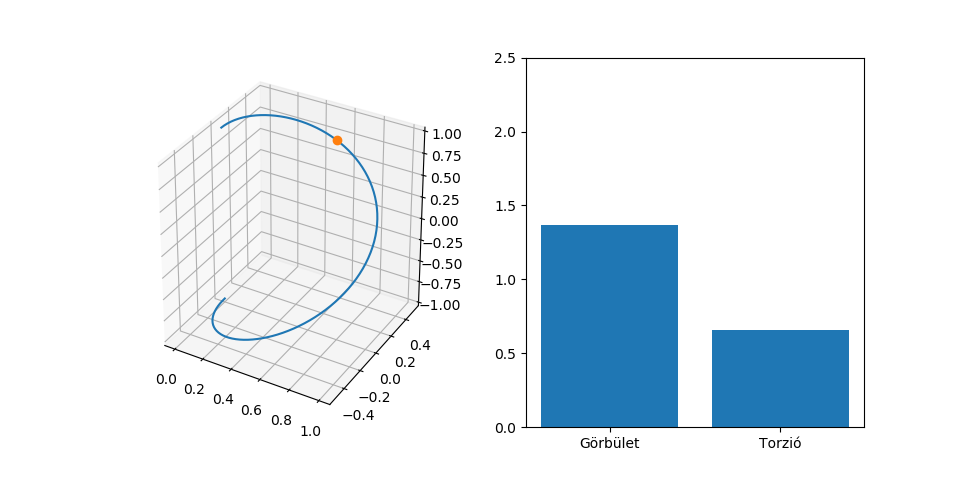

interactive(children=(FloatSlider(value=-1.5707963267948966, description='theta', max=1.5707963267948966, min=…

In [5]:
%matplotlib notebook
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

from ipywidgets import interact, interactive, fixed, interact_manual
import ipywidgets as widgets

# A Viviani-féle görbe
viviani = lambda t: np.array([np.cos(t)**2.0, np.cos(t)*np.sin(t), np.sin(t)])

# Görbület és torzió függvények
kappa = curvature(viviani)
tau   = torsion(viviani)

# Paraméter értékek
npts = 100
t = np.linspace(-0.5*np.pi,0.5*np.pi,npts)

# Függvényértékek kiszámítása
x, y, z  = [], [], []
for i in t:
    point = viviani(i)
    x.append(point[0])
    y.append(point[1])
    z.append(point[2])

x = np.array(x)
y = np.array(y)
z = np.array(z)

# Ábrázolás    
fig = plt.figure(figsize=plt.figaspect(0.5))

ax1 = fig.add_subplot(1,2,1, projection='3d')
ax2 = fig.add_subplot(1, 2, 2)

ax1.plot(x, y, z, label='Viviani-görbe')
point, = ax1.plot([x[0]], [y[0]], [z[0]], 'o')

@interact(theta=(-0.5*np.pi,0.5*np.pi,0.01))
def moving_point(theta=-0.5*np.pi):
    """
    Interaktív rajzolás
    """
    ax2.clear()
    ax2.set_ylim([0, 2.5])
    ax2.bar(["Görbület","Torzió"],[kappa(theta), tau(theta)])
    
    new_position = viviani(theta)
    point.set_data(new_position[0],new_position[1])
    point.set_3d_properties(new_position[2], 'z')
    

# Házi feladatok

## Feladat (Egy patologikus függvény)

Az 
$$
f(x)= \begin{cases}
x^2 \cos \left(\frac{1}{x}\right)\text{, ha }x\ne 0 \\
0\text{, ha }x=0
\end{cases}
$$
függvény $\mathbb{R}$-en mindenütt differenciálható, ám a deriváltja a $0$-ban nem folytonos.

\begin{enumerate}
    \item Ábrázoljuk $f$-et $[-1,1]$-en.
    \item Írjunk programot, melynek inputja a $h>0$ lépésköz, visszatérési értéke pedig az ezen lépésközhöz tartozó, valós számokon értelmezett függvényeken ható véges differencia operátor:
    $$
    D_h(f)(x)=\frac{f(x+h)-f(x)}{h}.
    $$
    \item Végül pedig számítsuk ki $f$ deriváltját kézzel és $h=0.01$ választás mellett ábrázoljuk a $[-1,1]$-on a
    $D_h(f)-f'$ és az $f'_a-f'$ approximációs hibákat, ahol $f'_a$ az autograd segítségével számolt deriváltat jelöli.
\end{enumerate}


## Feladat (Divergencia és rotáció két dimenzióban)

Tekintsünk egy $v:\mathbb{R}^2\to\mathbb{R}^2$ folytonosan differenciálható vektormezőt. A három dimenzióból ismert, rotáció kétdimenziós megfelelője a
$$
\mathrm{rot}\, v = \frac{\partial v_2}{\partial x}-\frac{\partial v_1}{\partial y}
$$
skalár értékű függvény, a divergencia pedig
$$
\mathrm{div}\, v = \frac{\partial v_1}{\partial x}+\frac{\partial v_2}{\partial y}.
$$

A divergencia és rotáció fizikai interpretációja szerint a divergencia a mező "forrásosságát", a rotáció pedig a vektormező "örvényességét" méri.

* **Első rész:** Írjunk Python programot, melynek inputja a $v$ vektormező, outputja pedig a $v$ mező rotációja.
* **Második rész:** Írjunk Python programot, melynek inputja a $v$ vektormező, outputja pedig a $v$ mező divergenciája.
* **Harmadik rész:** Írjunk programot, mellyel valamilyen érdekes (szolenoid mágneses tere, valamilyen áramlás, stb.) vektormező divergenciája és rotációja szépen ábrázolható. Javasolt megjelenítési módok: matplotlib quiver + pcolor közös koordinátarendszerben.

## Feladat ($\mathbb{R}^3$-beli felületek differenciálgeometriája)

Az $r:\mathbb{R}^2\to\mathbb{R}^3$, $(u,v)\mapsto r(u,v)$ kétszer folytonosan differenciálható függvény egy $\mathbb{R}^3$-ba ágyazott felület paraméterezése, amennyiben $r'_u\times r'_v$ seholsem nulla.

A felület Gauss-féle elsőrendű alapmennyiségei (Riemann geometriában a metrikus tenzora):
$$ 
g(u,v) = \left[ 
\begin{array}{cc}
E & F \\
F & G
\end{array}
\right],
$$
ahol $E=\langle r'_u, r'_u\rangle$, $F=\langle r'_u, r'_v\rangle$ és $G=\langle r'_v, r'_v\rangle$.

Ehhez némileg hasonlóan, a másodrendű deriváltak segítségével kaphatjuk meg a felület másodrendű alapmennyiségeit:
$$ 
K(u,v) = \left[ 
\begin{array}{cc}
L & M \\
M & N
\end{array}
\right],
$$
ahol $L=\langle r''_{uu}, n\rangle$, $M=\langle r''_{uv}, n\rangle$ és $N=\langle r''_{vv}, n\rangle$, $n$ pedig a felületi normális egységvektor
$$
n = \frac{r'_u\times r'_v}{\lVert r'_u\times r'_v\rVert}.
$$

A felület Gauss-görbületét (szorzatgörbületét) a
$$
\kappa = \frac{\mathrm{det}K}{\mathrm{det}g}=\frac{LN-M^2}{EG-F^2}
$$
formula szolgáltatja.

**A feladat első része:** Írjunk programot, melynek inputja az $(u,v)\mapsto r(u,v)$ paraméterezés, outputja pedig az $(u,v)\mapsto \kappa (u,v)\in\mathbb{R}$ Gauss-görbület.

**A feladat második része:** A Gauss-görbület számoló programunk segítségével számítsuk ki néhány, $(u,v)\mapsto [u,v,f(u,v)]^\top$ explicit megadású felület Gauss-görbületét és ábrázoljuk az $(u,v)\mapsto f(u,v)$ függvényt úgy, hogy grafikonját a Gauss-görbület szerint szinezzük.

# Kitekintés

Természetesen adódik a kérdés, hogy ha van Autograd, akkor létezik-e AutoInt, azaz automatikus határozatlan integrál számolás? Ismert, hogy a numerikus deriválással szemben a numerikus integrálás nem szenved stabilitási problémáktól, viszont elég műveletigényes (főleg a sokdimenziós integrálok kiszámítása), ezért hasznos lenne, ha (úgy, ahogy kézzel szoktuk) a számítógép a Newton-Leibnitz tétel sorozatos alkalmazásával (például téglalap tartományokon) integrálokat tudna számolni.  

A válasz az, hogy igen, vannak ilyen próbálkozások, de még elég gyerekcipőben jár a dolog. A https://arxiv.org/pdf/2006.15210.pdf cikk például bizonyos asszociatív algebrákat és az autograd segítségével előállított Taylor-polinomokat felhasználva mutat be egy lehetséges megvalósítást.

# Szorgalmi feladatok és kutatási témák

A félév során mindig örömmel fogadom és plusz ponttal honorálom:

* **Demonstrációs anyag (szép ábrák, animációk, 3D ábrák) készítése**

* **Érdekes alkalmazások megértése és leprogramozása (előzetes megbeszélés alapján)**

* **Saját projekt, melyben a hallgató (legalább részben) a tárgy anyagára támaszkodik**

Ezen felül TDK vagy BSc/MSc szakdolgozati témának ajánlom a Python lehetséges alkalmazásait a differenciálgeometriában /akár relativitáselméleti szimuláció is szóba jöhet/, a (kvantum) információgeometriában /=információelméleti és statisztikai problémák vizsgálata Riemann-geometriai eszközökkel/ és a gépi tanulásban (random iteratív algoritmusok).

# További olvasnivalók

1. https://en.wikipedia.org/wiki/Automatic_differentiation

2. https://en.wikipedia.org/wiki/Differentiable_programming

3. https://arxiv.org/pdf/1502.05767.pdf

4. https://www.kdnuggets.com/2020/09/autograd-best-machine-learning-library-not-using.html

5. https://autodiff-workshop.github.io/slides/BarakPearlmutter.pdf

6. https://www.cs.toronto.edu/~rgrosse/courses/csc421_2019/readings/L06%20Automatic%20Differentiation.pdf